
# Example: Bayesian Neural Network

We demonstrate how to use NUTS to do inference on a simple (small)
Bayesian neural network with two hidden layers.

<img src="file://../_static/img/examples/bnn.png" align="center">


In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# matplotlib.use("Agg")  # noqa: E402

sample: 100%|███████████████████████████████████████████| 4000/4000 [00:04<00:00, 865.21it/s, 511 steps of size 1.03e-02. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      5.89      2.02      5.68      2.66      9.01   1593.69      1.00
   w1[0,0]     -0.03      1.01      0.02     -1.70      1.58    365.21      1.00
   w1[0,1]     -0.09      1.02     -0.04     -1.83      1.47    314.06      1.00
   w1[0,2]      0.01      1.00      0.07     -1.64      1.55    390.12      1.00
   w1[0,3]     -0.06      1.00     -0.02     -1.67      1.58    431.05      1.00
   w1[0,4]      0.07      1.03      0.11     -1.59      1.71    362.71      1.00
   w1[1,0]      0.37      1.07      0.45     -1.35      2.07    603.45      1.00
   w1[1,1]      0.36      1.05      0.41     -1.33      2.10    531.11      1.00
   w1[1,2]      0.34      1.06      0.40     -1.40      2.00    483.17      1.00
   w1[1,3]      0.35      1.07      0.40     -1.46      2.01    611.36      1.00
   w1[1,4]      0.32      1.05      0.37     -1.47      1.94    491.84      1.00
   w1[2,0]      0.15      1

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

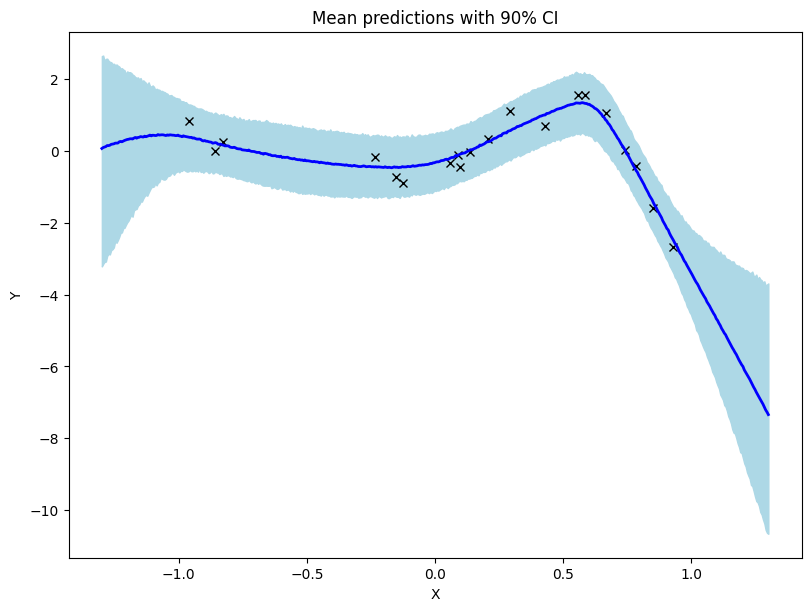

In [83]:
# the non-linearity we use in our neural network
def nonlin(x):
    return jnp.maximum(0, x)
#     return jnp.sign(x)
#     return jnp.tanh(x)


# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H, D_Y=1):
    N, D_X = X.shape

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    assert w1.shape == (D_X, D_H)
    z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations
    assert z1.shape == (N, D_H)

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    assert w2.shape == (D_H, D_H)
    z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations
    assert z2.shape == (N, D_H)

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    assert w3.shape == (D_H, D_Y)
    z3 = jnp.matmul(z2, w3)  # <= output of the neural network
    assert z3.shape == (N, D_Y)

    if Y is not None:
        assert z3.shape == Y.shape

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    with numpyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)


# helper function for HMC inference
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]


# create artificial regression dataset
def get_data(N=50, D_X=3, D_Y=1, sigma_obs=0.05, N_test=500, rng_seed=0):
    np.random.seed(rng_seed)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test



N, D_X, D_H = 20, 3, 5 # args.num_data, 3, args.num_hidden
X, Y, X_test = get_data(N=N, D_X=D_X)

# do inference
num_warmup, num_samples, num_chains = 1000, 3000, 1
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y, D_H)

# predict Y_test at inputs X_test
vmap_args = (
    samples,
    random.split(rng_key_predict, num_samples * num_chains),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H)
)(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X_test[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)

# plot mean prediction
ax.plot(X_test[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_89723/440337029.py:49: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 10745.48it/s, 31 steps of size 1.67e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.10      0.54      0.04     -0.73      1.19     82.18      1.04
         b     -0.00      0.68      0.02     -1.08      1.28    393.95      1.01
  prec_obs      6.85      0.70      6.83      5.77      8.07    244.60      1.03

Number of divergences: 41

MCMC elapsed time: 2.1599950790405273


Text(0.5, 1.0, 'Posterior samples')

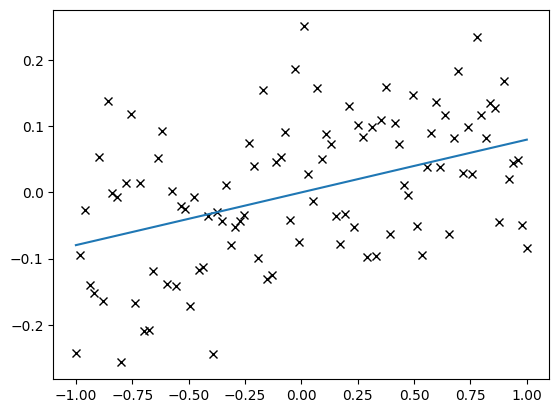

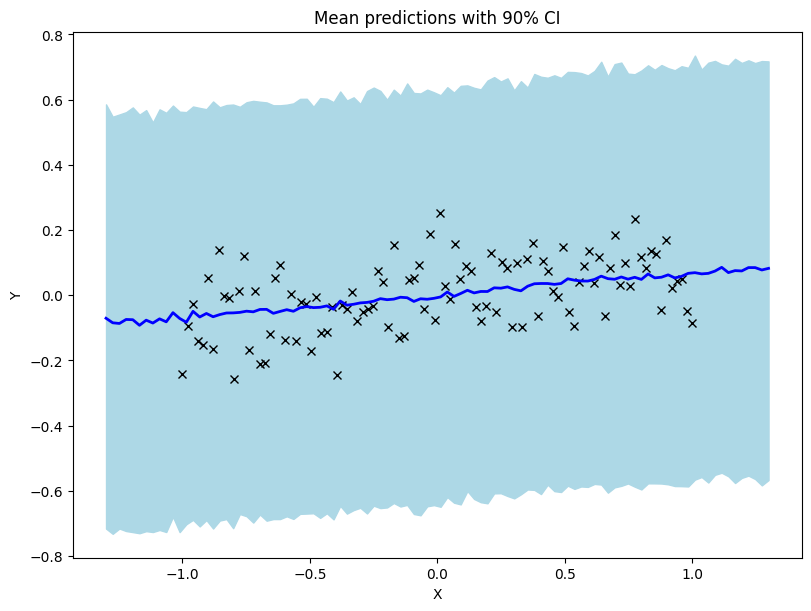

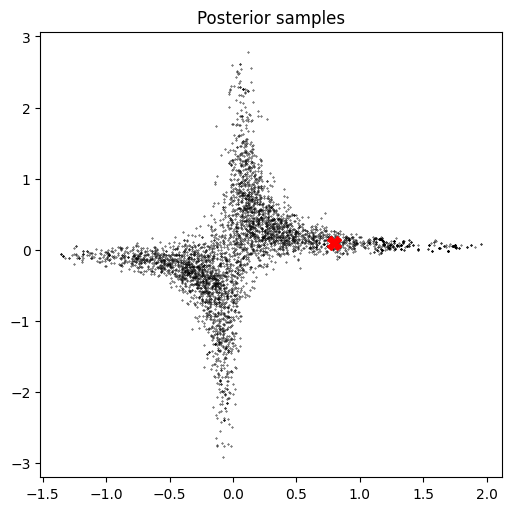

In [276]:
def tanh_2D_model(X, Y):
    num_samples, input_dim = X.shape
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    y_hat = a * jnp.tanh(b * X)
    
    # we put a prior on the observation noise
    prec_obs = numpyro.sample(
        "prec_obs", 
        dist.Normal(0, 1.0)
#         dist.Gamma(3.0, 1.0)
    )
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    with numpyro.plate("data", num_samples):
        # note we use to_event(1) because each observation has shape (1,)
        numpyro.sample("Y", dist.Normal(y_hat, sigma_obs).to_event(1), obs=Y)
    return 

        
# helper function for HMC inference
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

# helper function for prediction
def predict(model, rng_key, samples, X):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None)
    return model_trace["Y"]["value"]


def get_data(true_param, num_samples=50, sigma=0.05, num_test=500, rng_seed=0):
    X = np.linspace(-1, 1, num=num_samples)
    Y = true_param["a"] * np.tanh(true_param["b"] * X)
    Y += sigma * np.random.randn(num_samples)
    X = X[:, np.newaxis]
    Y = Y[:, np.newaxis]
    X_test = np.linspace(-1.3, 1.3, num=num_test)
    X_test = X_test[:, np.newaxis]
    return X, Y, X_test

true_param = {
    "a": 0.8, 
    "b": 0.1
}

num_samples = 100
sigma = 0.1
X, Y, X_test = get_data(true_param, num_samples=num_samples, sigma=sigma, num_test=100, rng_seed=0)

plt.plot(X, Y, "kx")
x = np.linspace(-1, 1, num=50)
plt.plot(x, true_param["a"] * jnp.tanh(true_param["b"] * x))

# do inference
num_warmup, num_samples, num_chains = 1000, 1000, 4
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(tanh_2D_model, num_warmup, num_samples, num_chains, rng_key, X, Y)

# predict Y_test at inputs X_test
vmap_args = (
    samples,
    random.split(rng_key_predict, num_samples * num_chains),
)
predictions = vmap(
    lambda samples, rng_key: predict(tanh_2D_model, rng_key, samples, X_test)
)(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X_test[:, 0], percentiles[0, :], percentiles[1, :], color="lightblue"
)

# plot mean prediction
ax.plot(X_test[:, 0], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")


fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.plot(samples["a"], samples["b"], "kx", markersize=1, alpha=0.5)
ax.plot([true_param["a"]], [true_param["b"]], "rX", markersize=10)
ax.set_title("Posterior samples")